In [42]:
# Neural Net with Random Optimization
%matplotlib inline
%mkdir figures
%load_ext autoreload
%autoreload 2
# TODO: generate perf vs iterations graph, 
import mlrose
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from load_data import load_diabetes
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import accuracy_score

seed = 1
x, y = load_diabetes()
# x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=.2, stratify=y, random_state=seed)
kf = KFold(n_splits=5)
np.random.seed(seed)
acc_tr = {}
time_tr = {}
acc_te = {}

mkdir: cannot create directory ‘figures’: File exists
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
def evaluate(algo_name, param_name, clf, kf):
    # Warning, this does not clear itself
    if algo_name not in acc_tr:
        acc_tr[algo_name] = {}
        acc_te[algo_name] = {}
        time_tr[algo_name] = {}
    if param_name not in acc_tr[algo_name]:
        acc_tr[algo_name][param_name] = []
        acc_te[algo_name][param_name] = []
        time_tr[algo_name][param_name] = []
    eval_time = []
    eval_tr = []
    eval_te = []
    for train_index, test_index in kf.split(x):
        x_tr, x_te = x[train_index], x[test_index]
        y_tr, y_te = y[train_index], y[test_index]
        time_start = datetime.now()
        clf.fit(x_tr, y_tr)
        eval_time.append((datetime.now() - time_start).microseconds)
        y_train_pred = clf.predict(x_tr)
        y_te_pred = clf.predict(x_te)
        y_train_accuracy = accuracy_score(y_tr, y_train_pred)
        y_te_accuracy = accuracy_score(y_te, y_te_pred)
        eval_tr.append(y_train_accuracy)    
        eval_te.append(y_te_accuracy)
    eval_time = np.array(eval_time).mean() / 1000
    eval_tr = np.array(eval_tr).mean()
    eval_te = np.array(eval_te).mean()
    acc_tr[algo_name][param_name].append(eval_tr)
    acc_te[algo_name][param_name].append(eval_te)    
    time_tr[algo_name][param_name].append(eval_time)    

In [36]:
iteration_range = range(250, 2250, 250)

In [43]:
# Neural Net: https://scikit-learn.org/stable/modules/neural_networks_supervised.html
# Sample sanity run - benchmark acc

for it in iteration_range:
    print("Eval iter", it)
    algo = 'backprop'
    clf = mlrose.NeuralNetwork(hidden_nodes = [6], activation = 'relu', \
                                     algorithm = 'gradient_descent', max_iters = it, \
                                     bias = True, is_classifier = True, learning_rate = 0.0001, \
                                     early_stopping = True, clip_max = 5, max_attempts = 100)
    evaluate(algo, 'iter', clf, kf)
    algo= 'rhc'
    clf = mlrose.NeuralNetwork(hidden_nodes = [6], activation = 'relu', \
                                     algorithm = 'random_hill_climb', max_iters = it, \
                                     bias = True, is_classifier = True, learning_rate = 0.0001, \
                                     early_stopping = True, clip_max = 5, restarts=5, max_attempts = 100)
    evaluate(algo, 'iter', clf, kf)
    algo = 'sa'
    clf = mlrose.NeuralNetwork(hidden_nodes = [6], activation = 'relu', \
                                     algorithm = 'simulated_annealing', max_iters = it, \
                                     bias = True, is_classifier = True, learning_rate = 0.0001, \
                                     early_stopping = True, clip_max = 5, max_attempts = 100)
    evaluate(algo, 'iter', clf, kf)
    algo='ga'
    clf = mlrose.NeuralNetwork(hidden_nodes = [6], activation = 'relu', \
                                     algorithm = 'genetic_alg', max_iters = it, \
                                     bias = True, is_classifier = True, learning_rate = 0.0001, \
                                     early_stopping = True, clip_max = 5, max_attempts = 100)
    evaluate(algo, 'iter', clf, kf)

Eval iter 250
Eval iter 500
Eval iter 750
Eval iter 1000
Eval iter 1250
Eval iter 1500


/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))


Eval iter 1750
Eval iter 2000


In [108]:
algo = 'rhc'
param = 'restarts'
restart_range = range(0, 10, 1)
acc_tr[algo][param] = []
acc_te[algo][param] = []
time_tr[algo][param] = []
for res in restart_range:
    clf = mlrose.NeuralNetwork(hidden_nodes = [6], activation = 'relu', \
                                     algorithm = 'random_hill_climb', max_iters = 1000, \
                                     bias = True, is_classifier = True, learning_rate = 0.0001, \
                                     early_stopping = True, clip_max = 5, restarts=res, max_attempts = 100)
    evaluate(algo, 'restarts', clf, kf)

In [112]:
def graph_info(algo, gr, in_range):
    plt.plot(in_range, time_tr[algo][gr])
    plt.xlabel(gr)
    plt.ylabel('time (ms)')
    plt.title('time vs {}'.format(gr))
    plt.savefig('figures/time_{}_{}.png'.format(algo, gr))
    plt.clf()
    plt.plot(in_range, acc_tr[algo][gr], label="tr")
    plt.plot(in_range, acc_te[algo][gr], label="te")
    plt.legend()
    plt.title("accuracy vs {}".format(gr))
    plt.xlabel(gr)
    plt.ylabel("accuracy")
    plt.savefig('figures/acc_{}_{}.png'.format(algo, gr))

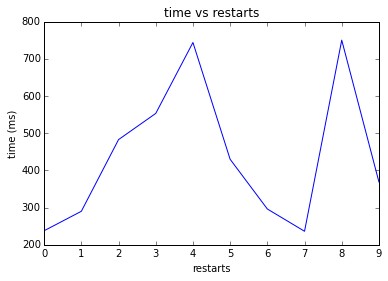

In [114]:
graph_info('rhc', 'restarts', restart_range)

In [88]:
algo = 'sa'
dec_range = [.9, .95, .99, .995, .999]
for dec in dec_range:
    clf = mlrose.NeuralNetwork(hidden_nodes = [6], activation = 'relu', \
                                     algorithm = 'simulated_annealing', max_iters = 1000, \
                                     bias = True, is_classifier = True, learning_rate = 0.0001, \
                                     early_stopping = True, clip_max = 5, schedule=mlrose.GeomDecay(decay=dec), max_attempts = 100)
    evaluate(algo, 'decay', clf, kf)

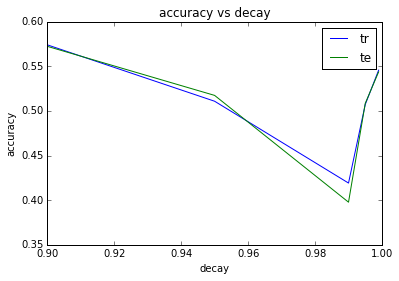

In [94]:
graph_info('sa', 'decay', dec_range)

In [110]:
algo = 'ga'
param = 'pop'
pop_size = range(100, 375, 25)
acc_tr[algo][param] = []
acc_te[algo][param] = []
time_tr[algo][param] = []
for pop in pop_size:
    clf = mlrose.NeuralNetwork(hidden_nodes = [6], activation = 'relu', \
                                     algorithm = 'genetic_alg', max_iters = 1000, \
                                     bias = True, is_classifier = True, learning_rate = 0.0001, \
                                     early_stopping = True, clip_max = 5, pop_size=pop, max_attempts = 100)
    evaluate(algo, 'pop', clf, kf)

/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))


[0.6440881870015038, 0.6610459586271394, 0.6375783113964004, 0.6466882050682552, 0.6414190901796579, 0.6117635806175641, 0.6434223740774001, 0.6825384848372132, 0.6639626762172474, 0.6050092724944338, 0.6587265065810798]


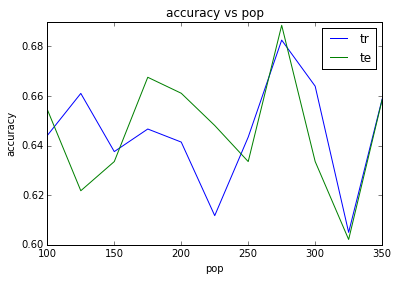

In [111]:
print(acc_tr['ga']['pop'])
graph_info('ga', 'pop', pop_size)

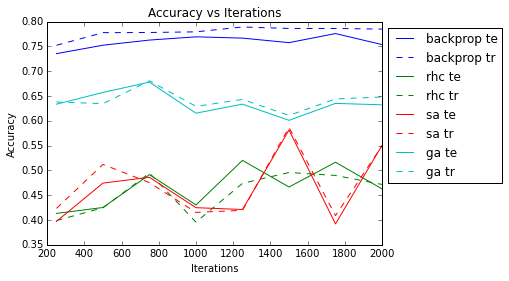

In [61]:
# Plot all graphs - first make comparison on iterations
plt.plot(iteration_range, acc_te['backprop']['iter'], label='backprop te', linestyle='-', color='b')
plt.plot(iteration_range, acc_tr['backprop']['iter'], label='backprop tr', linestyle='--', color='b')

plt.plot(iteration_range, acc_te['rhc']['iter'], label='rhc te', linestyle='-', color='g')
plt.plot(iteration_range, acc_tr['rhc']['iter'], label='rhc tr', linestyle='--', color='g')

plt.plot(iteration_range, acc_te['sa']['iter'], label='sa te', linestyle='-', color='r')
plt.plot(iteration_range, acc_tr['sa']['iter'], label='sa tr', linestyle='--', color='r')

plt.plot(iteration_range, acc_te['ga']['iter'], label='ga te', linestyle='-', color='c')
plt.plot(iteration_range, acc_tr['ga']['iter'], label='ga tr', linestyle='--', color='c')
plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.title("Accuracy vs Iterations")
plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.savefig('figures/net_acc_iter.png')

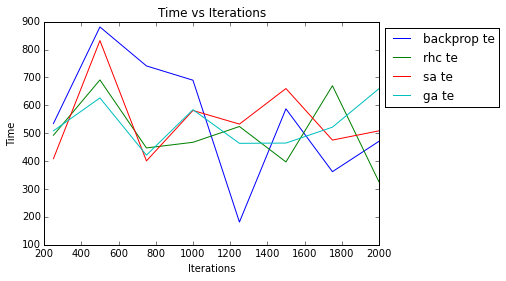

In [115]:
# Plot all graphs - first make comparison on iterations
plt.plot(iteration_range, time_tr['backprop']['iter'], label='backprop te', linestyle='-', color='b')

plt.plot(iteration_range, time_tr['rhc']['iter'], label='rhc te', linestyle='-', color='g')

plt.plot(iteration_range, time_tr['sa']['iter'], label='sa te', linestyle='-', color='r')

plt.plot(iteration_range, time_tr['ga']['iter'], label='ga te', linestyle='-', color='c')
plt.ylabel("Time")
plt.xlabel("Iterations")
plt.title("Time vs Iterations")
plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.savefig('figures/net_time_iter.png')